<a href="https://colab.research.google.com/github/gabisponciano/Bootcamp_Atv04_parte03/blob/main/demode_melhorar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas e Depedências

In [ ]:
!pip install opendatasets
!pip install pandas
!pip install imagehash
!pip install glob
!pip install kagglehub
!pip install tensorflow
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [ ]:
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import os
import kagglehub
import glob
import imagehash
%matplotlib inline
import random
import shutil
from PIL import Image
from collections import defaultdict
from imgaug import augmenters as iaa
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

In [ ]:
od.download("https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gabrielaponciano
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset


100%|██████████| 195M/195M [00:09<00:00, 20.7MB/s]


In [ ]:
root_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# **Análise dos dados**

In [ ]:
count_corrupted = 0
corrupted = list()

In [ ]:
dataframe_list = list()
for folder in os.listdir(root_dir):
  child_dir = os.path.join(root_dir, folder)

  for image in os.listdir(child_dir):
    img_dir = os.path.join(child_dir, image)
    _, image_format = image.split('.')
    img = cv2.imread(img_dir)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if img is not None:
      # Converter a imagem OpenCV para uma imagem do Pillow
      img_pil = Image.fromarray(img_rgb)

      # Gerar o hash da imagem (usando perceptual hash como exemplo)
      img_hash = imagehash.phash(img_pil)
      width, height, channels = img.shape
      img_corrupted = False
    else:
      count_corrupted += 1
      corrupted.append(img_dir)
      img_corrupted = True
      img_hash, image_format, width, height, channels = None, None, None, None, None

    dataframe_list.append([img_dir, img_corrupted, img_hash, image_format, width, height, channels, folder])

In [ ]:
df = pd.DataFrame(columns=['image_path', 'corrupted', 'image_hash', 'image_format', 'width', 'height', 'channels', 'label'], data = dataframe_list)

In [ ]:
df.describe().loc[['mean', 'std', 'min', 'max']]

,width,height,channels
mean,501.586819,616.080482,3.0
std,76.609025,122.068836,0.0
min,310.000000,190.000000,3.0
max,719.000000,1048.000000,3.0


<ipython-input-9-1db12c7c1873>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=image_format_counts.index, y=image_format_counts.values, palette="Greens", width=0.40)


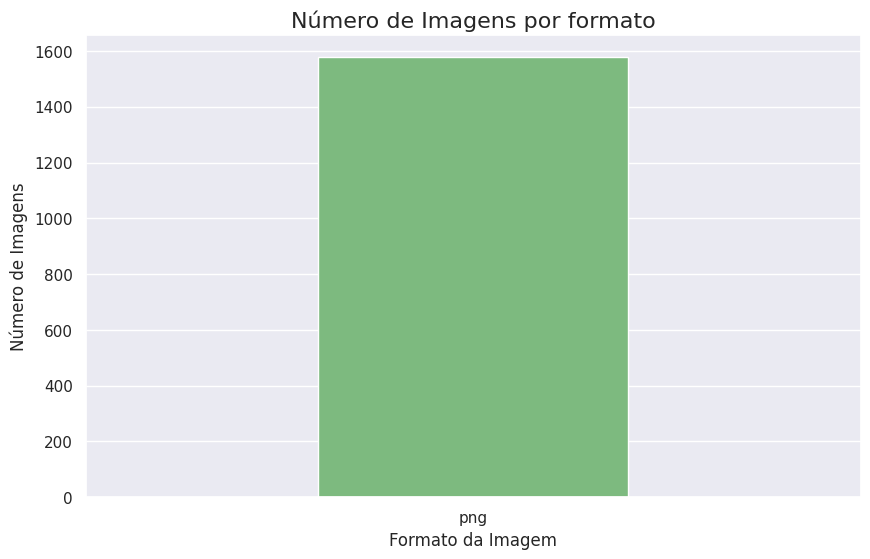

In [ ]:
sns.set(style="darkgrid")

image_format_counts = df['image_format'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=image_format_counts.index, y=image_format_counts.values, palette="Greens", width=0.40)

plt.title('Número de Imagens por formato', fontsize=16)
plt.xlabel('Formato da Imagem', fontsize=12)
plt.ylabel('Número de Imagens', fontsize=12)

plt.show()

In [ ]:
## Benigno
diretorio_benign = "/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign"

image_count = 0
for subdir, dirs, files in os.walk(diretorio_benign):
    for file in files:
        if file.endswith(('.png')):
            image_count += 1

print(f"Total de imagens no diretório de benigno: {image_count}")

## Normal
diretorio_normal = "/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal"

image_count = 0

for subdir, dirs, files in os.walk(diretorio_normal):
    for file in files:
        if file.endswith(('.png')):
            image_count += 1

print(f"Total de imagens no diretório normal: {image_count}")

#Maligno
diretorio_malignant = "/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant"

image_count = 0

for subdir, dirs, files in os.walk(diretorio_malignant):
    for file in files:
        if file.endswith(('.png')):
            image_count += 1

print(f"Total de imagens no diretório maligno: {image_count}")

Total de imagens no diretório de benigno: 891
Total de imagens no diretório normal: 266
Total de imagens no diretório maligno: 421


In [ ]:
# Quantidade de imagens corrompidas
count_corrupted

0

In [ ]:
df_images = pd.DataFrame(dataframe_list, columns=['Path', 'Corrupted', 'Hash', 'Format', 'Width', 'Height', 'Channels', 'Folder'])
print(f"Imagens corrompidas: {count_corrupted}")
print(df_images.head(15))

Imagens corrompidas: 0
                                                 Path  Corrupted  \
0   /content/breast-ultrasound-images-dataset/Data...      False   
1   /content/breast-ultrasound-images-dataset/Data...      False   
2   /content/breast-ultrasound-images-dataset/Data...      False   
3   /content/breast-ultrasound-images-dataset/Data...      False   
4   /content/breast-ultrasound-images-dataset/Data...      False   
5   /content/breast-ultrasound-images-dataset/Data...      False   
6   /content/breast-ultrasound-images-dataset/Data...      False   
7   /content/breast-ultrasound-images-dataset/Data...      False   
8   /content/breast-ultrasound-images-dataset/Data...      False   
9   /content/breast-ultrasound-images-dataset/Data...      False   
10  /content/breast-ultrasound-images-dataset/Data...      False   
11  /content/breast-ultrasound-images-dataset/Data...      False   
12  /content/breast-ultrasound-images-dataset/Data...      False   
13  /content/breast-ultra

In [ ]:
# Verifica valores ausentes
valores_ausentes = df.isnull().sum()

print("Valores ausentes em cada coluna:")
print(valores_ausentes[valores_ausentes > 0])

Valores ausentes em cada coluna:
Series([], dtype: int64)


In [ ]:
# Definindo limites esperados para largura e altura
largura_minima = 150
largura_maxima = 800
altura_minima = 150
altura_maxima = 1200

# Verificando dimensões inconsistentes
dimensoes_inconsistentes = df[(df['width'] < largura_minima) |
                               (df['width'] > largura_maxima) |
                               (df['height'] < altura_minima) |
                               (df['height'] > altura_maxima)]

# Exibindo resultados
if not dimensoes_inconsistentes.empty:
    print("Dimensões inconsistentes encontradas:")
    print(dimensoes_inconsistentes[['image_path', 'width', 'height']])
else:
    print("Todas as dimensões das imagens estão dentro dos limites esperados.")

Todas as dimensões das imagens estão dentro dos limites esperados.


In [ ]:
print(df.dtypes)

image_path      object
corrupted         bool
image_hash      object
image_format    object
width            int64
height           int64
channels         int64
label           object
dtype: object


In [ ]:
duplicatas = df[df.duplicated(subset='image_path', keep=False)]
if not duplicatas.empty:
    print("Imagens duplicadas encontradas:")
    print(duplicatas[['image_path']])
else:
    print("Não foram encontradas imagens duplicadas.")

Não foram encontradas imagens duplicadas.


In [ ]:
root_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
arquivos = [i for i in glob.glob(root_dir + "/*/*/*")]
labels = [os.root_dir.dirname(i).split('/')[-1] for i in arquivos]
data = zip(arquivos, labels)
df_dist = pd.DataFrame(data, columns=['Caminho', 'Labels'])
df_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Caminho  0 non-null      object
 1   Labels   0 non-null      object
dtypes: object(2)
memory usage: 124.0+ bytes


In [ ]:
# Função para calcular o hash da imagem
def calculate_image_hash(image_path):
    image = Image.open(image_path)
    return imagehash.average_hash(image)

# Dicionário para armazenar hashes e seus caminhos de imagem
hash_dict = defaultdict(list)

# Percorrer diretório e subdiretórios
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
            file_path = os.path.join(subdir, file)
            img_hash = calculate_image_hash(file_path)
            hash_dict[img_hash].append(file_path)

# Encontrar e listar imagens duplicadas
duplicates = {k: v for k, v in hash_dict.items() if len(v) > 1}

# Exibir resultados
if duplicates:
    count = 0
    print("Imagens duplicadas encontradas:")
    for img_hash, paths in duplicates.items():
        for path in paths:
            count = count + 1
    print(f" - {count}")
else:
    print("Nenhuma imagem duplicada encontrada.")


Imagens duplicadas encontradas:
 - 550


## **Pré-Processamento**

# Retirando duplicatas - Não Implementado

In [ ]:
import os
import cv2
import imagehash
from PIL import Image
from collections import defaultdict

# Diretório raiz
root_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Função para calcular o hash da imagem
def calculate_image_hash(image_path):
    image = Image.open(image_path)
    return imagehash.average_hash(image)

# Verificar e remover duplicatas
hash_dict = defaultdict(list)
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
            file_path = os.path.join(subdir, file)
            img_hash = calculate_image_hash(file_path)
            hash_dict[img_hash].append(file_path)

# Encontrar e remover duplicatas (mantendo apenas uma cópia)
for img_hash, paths in hash_dict.items():
    if len(paths) > 1:
        for path in paths[1:]:
            os.remove(path)

# Contar e salvar imagens restantes em cada pasta
counts = {'benign': 0, 'malignant': 0, 'normal': 0}
for category in counts.keys():
    category_dir = os.path.join(root_dir, category)
    for _, _, files in os.walk(category_dir):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                counts[category] += 1
                file_path = os.path.join(category_dir, file)
                # Reabrir e salvar a imagem para confirmar que está salva
                with Image.open(file_path) as img:
                    img.save(file_path)

# Exibir contagem de imagens restantes
for category, count in counts.items():
    print(f'Pasta {category}: {count} imagens restantes.')

Pasta benign: 670 imagens restantes.
Pasta malignant: 376 imagens restantes.
Pasta normal: 112 imagens restantes.


In [ ]:
import os

# Diretório raiz
root_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Função para contar imagens em cada categoria
def count_images(directory):
    counts = {'benign': 0, 'malignant': 0, 'normal': 0}

    for category in counts.keys():
        category_dir = os.path.join(directory, category)
        if os.path.isdir(category_dir):
            for file in os.listdir(category_dir):
                if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                    counts[category] += 1

    return counts

# Chamar a função e exibir os resultados
image_counts = count_images(root_dir)

for category, count in image_counts.items():
    print(f'Pasta {category}: {count} imagens')


Pasta benign: 670 imagens
Pasta malignant: 376 imagens
Pasta normal: 112 imagens


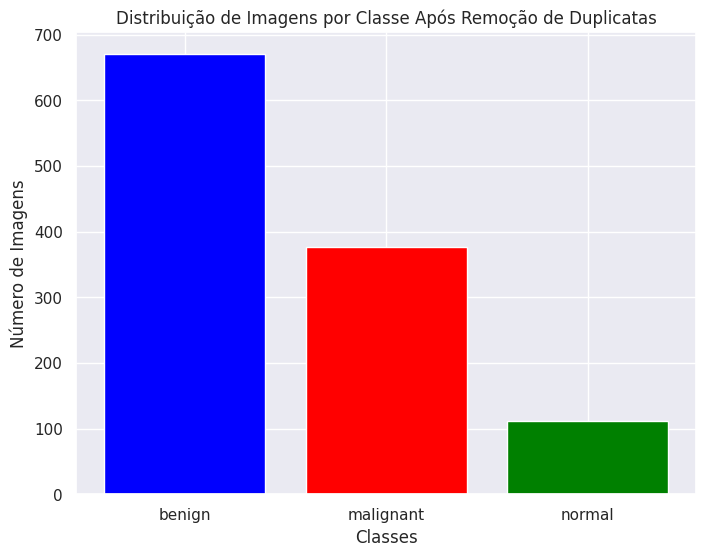

In [ ]:
def plot_distribution(counts):
    categories = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(categories, values, color=['blue', 'red', 'green'])
    plt.title("Distribuição de Imagens por Classe Após Remoção de Duplicatas")
    plt.xlabel("Classes")
    plt.ylabel("Número de Imagens")
    plt.show()

# Chamar a função para gerar o gráfico
plot_distribution(counts)

# Redimensionando

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Tamanhos desejados
new_width = 224
new_height = 224

# Função para redimensionar, salvar e mostrar imagens
def process_and_save_images(directory, num_images=4):
    images_displayed = 0
    plt.figure(figsize=(10, 10))

    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                if images_displayed >= num_images:
                    break
                file_path = os.path.join(subdir, file)
                image = cv2.imread(file_path)

                # Redimensionar a imagem
                resized_image = cv2.resize(image, (new_width, new_height))

                # Salvar a imagem redimensionada
                cv2.imwrite(file_path, resized_image)

                # Mostrar as imagens original e redimensionada
                plt.subplot(2, 4, images_displayed * 2 + 1)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title('Imagem Original')
                plt.axis('off')

                plt.subplot(2, 4, images_displayed * 2 + 2)
                plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
                plt.title('Imagem Redimensionada')
                plt.axis('off')

                images_displayed += 1

        if images_displayed >= num_images:
            break

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Diretório raiz
root_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

In [ ]:
# Tamanhos desejados
new_width = 224
new_height = 224

# Função para redimensionar e salvar imagens
def resize_and_save_images(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                file_path = os.path.join(subdir, file)

                # Abrir a imagem
                with Image.open(file_path) as img:
                    # Redimensionar a imagem
                    resized_image = img.resize((new_width, new_height))
                    # Salvar a imagem redimensionada
                    resized_image.save(file_path)


In [ ]:
# Função para mostrar imagens redimensionadas
def display_images(directory, num_images=4):
    images_displayed = 0
    plt.figure(figsize=(10, 10))

    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                if images_displayed >= num_images:
                    break
                file_path = os.path.join(subdir, file)

                # Abrir a imagem redimensionada
                image = cv2.imread(file_path)

                # Mostrar a imagem redimensionada
                plt.subplot(1, num_images, images_displayed + 1)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title('Imagem Redimensionada')
                plt.axis('off')

                images_displayed += 1

    plt.tight_layout()
    plt.show()


In [ ]:
# Função para obter as dimensões das imagens
def get_image_dimensions(directory):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                try:
                    with Image.open(image_path) as img:
                        width, height = img.size
                        print(f'Imagem: {image_name} | Dimensões: {width}x{height}')
                except Exception as e:
                    print(f"Erro ao abrir {image_name}: {e}")


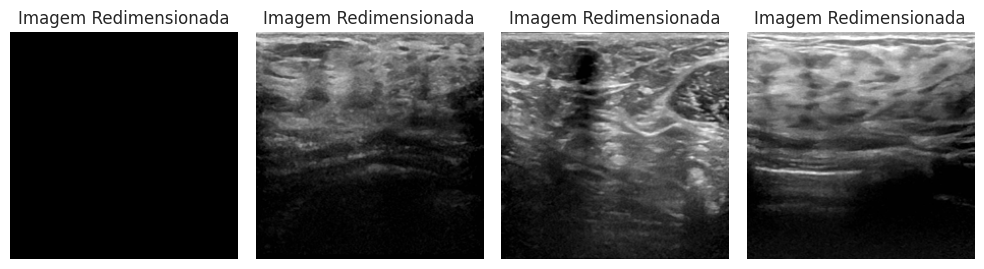

Imagem: normal (2)_mask.png | Dimensões: 224x224
Imagem: normal (38).png | Dimensões: 224x224
Imagem: normal (39).png | Dimensões: 224x224
Imagem: normal (30).png | Dimensões: 224x224
Imagem: normal (110)_mask.png | Dimensões: 224x224
Imagem: normal (133).png | Dimensões: 224x224
Imagem: normal (74)_mask.png | Dimensões: 224x224
Imagem: normal (20)_mask.png | Dimensões: 224x224
Imagem: normal (3)_mask.png | Dimensões: 224x224
Imagem: normal (104)_mask.png | Dimensões: 224x224
Imagem: normal (46)_mask.png | Dimensões: 224x224
Imagem: normal (65).png | Dimensões: 224x224
Imagem: normal (65)_mask.png | Dimensões: 224x224
Imagem: normal (113).png | Dimensões: 224x224
Imagem: normal (5).png | Dimensões: 224x224
Imagem: normal (87).png | Dimensões: 224x224
Imagem: normal (75).png | Dimensões: 224x224
Imagem: normal (125).png | Dimensões: 224x224
Imagem: normal (3).png | Dimensões: 224x224
Imagem: normal (75)_mask.png | Dimensões: 224x224
Imagem: normal (10)_mask.png | Dimensões: 224x224
Imag

In [ ]:
resize_and_save_images(root_dir)
display_images(root_dir)
get_image_dimensions(root_dir)


# Normalizando


Mostrando imagens da pasta: benign


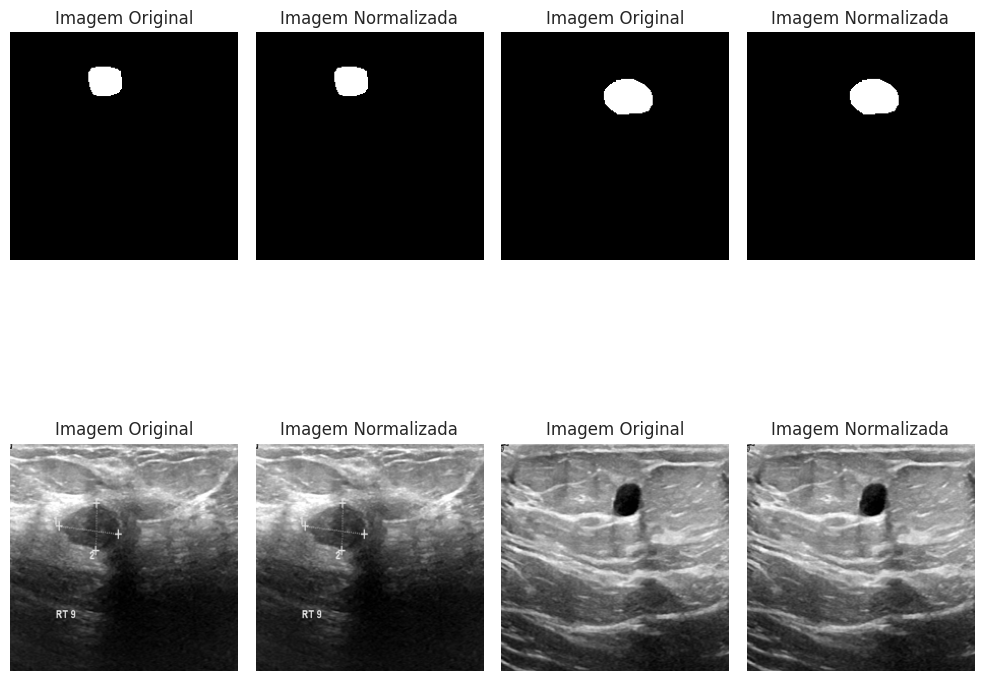


Mostrando imagens da pasta: malignant


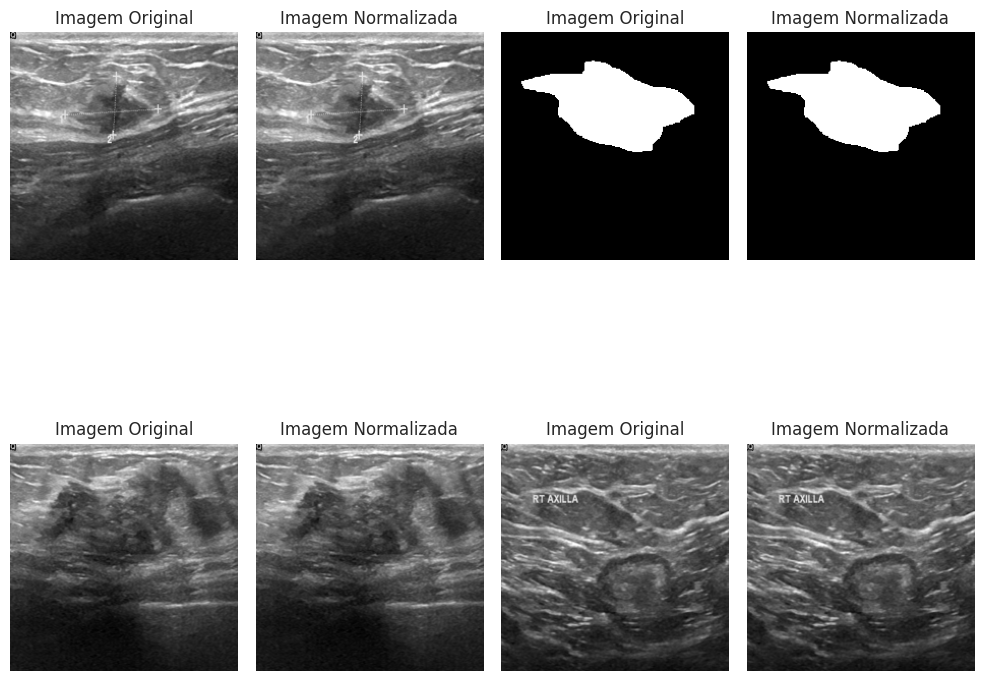


Mostrando imagens da pasta: normal


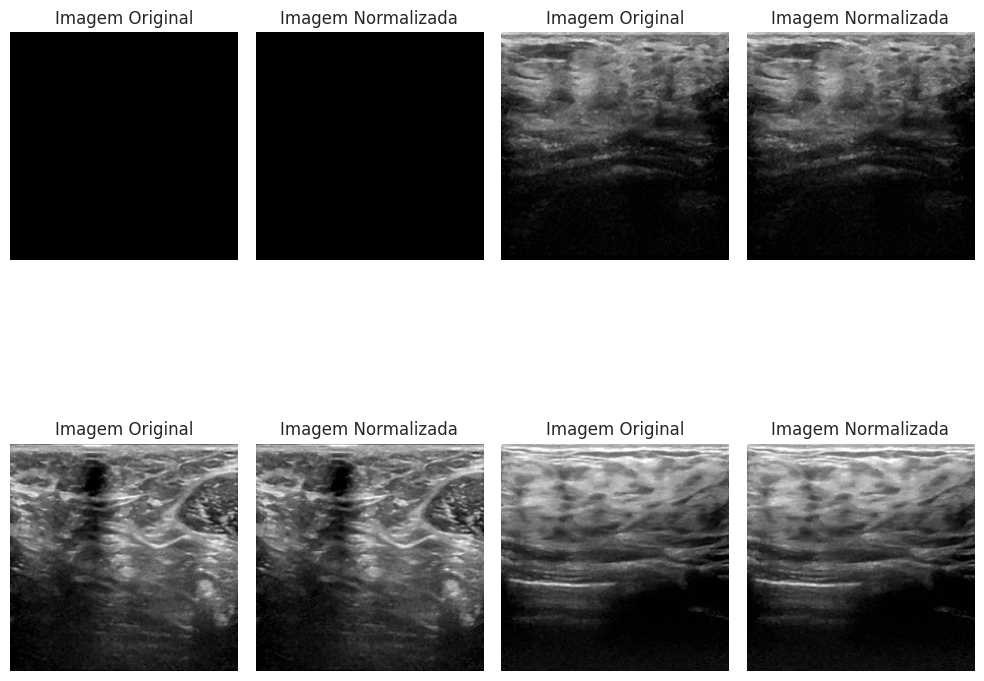

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Diretório raiz
root_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Função para normalizar, salvar e mostrar imagens
def normalize_save_and_display_images(directory, num_images=4):
    images_displayed = 0
    plt.figure(figsize=(10, 10))

    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                file_path = os.path.join(subdir, file)

                # Abrir a imagem
                image = cv2.imread(file_path)
                if image is None:
                    print(f"Erro ao abrir a imagem: {file_path}")
                    continue

                # Normalizar a imagem (valores entre 0 e 1)
                normalized_image = image / 255.0

                # Converter de volta para uint8 para salvar
                normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

                # Salvar a imagem normalizada
                cv2.imwrite(file_path, normalized_image_uint8)

                # Mostrar as imagens original e normalizada
                if images_displayed < num_images:
                    plt.subplot(2, 4, images_displayed * 2 + 1)
                    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                    plt.title('Imagem Original')
                    plt.axis('off')

                    plt.subplot(2, 4, images_displayed * 2 + 2)
                    plt.imshow(cv2.cvtColor(normalized_image_uint8, cv2.COLOR_BGR2RGB))
                    plt.title('Imagem Normalizada')
                    plt.axis('off')

                    images_displayed += 1

        if images_displayed >= num_images:
            break

    plt.tight_layout()
    plt.show()

# Processar, normalizar, salvar e mostrar as imagens no diretório raiz
for category in ['benign', 'malignant', 'normal']:
    print(f'\nMostrando imagens da pasta: {category}')
    category_dir = os.path.join(root_dir, category)
    normalize_save_and_display_images(category_dir)



# Correção de contraste - Não implementado

In [ ]:
# Função para corrigir o contraste usando CLAHE
def adjust_contrast_clahe(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                file_path = os.path.join(subdir, file)
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                # Aplicar CLAHE para realce adaptativo de contraste
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                clahe_image = clahe.apply(image)

                # Salvar a imagem com CLAHE aplicado
                cv2.imwrite(file_path, clahe_image)

# Aplicar CLAHE nas imagens do diretório raiz
for category in counts.keys():
    category_dir = os.path.join(root_dir, category)
    adjust_contrast_clahe(category_dir)

NameError: name 'counts' is not defined

# Redução de Ruído - Não implementado

In [ ]:
# Função para reduzir ruído
def denoise_images(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                file_path = os.path.join(subdir, file)
                image = cv2.imread(file_path)

                # Redução de ruído usando filtro bilateral
                denoised_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

                # Salvar a imagem com ruído reduzido
                cv2.imwrite(file_path, denoised_image)

# Reduzir o ruído das imagens no diretório raiz
for category in counts.keys():
    category_dir = os.path.join(root_dir, category)
    denoise_images(category_dir)

NameError: name 'counts' is not defined


Mostrando imagens da pasta: benign


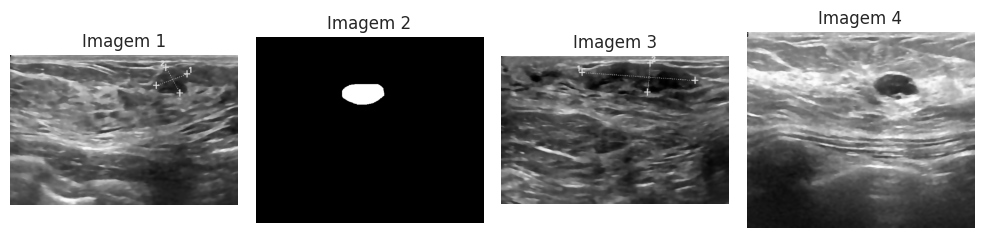


Mostrando imagens da pasta: malignant


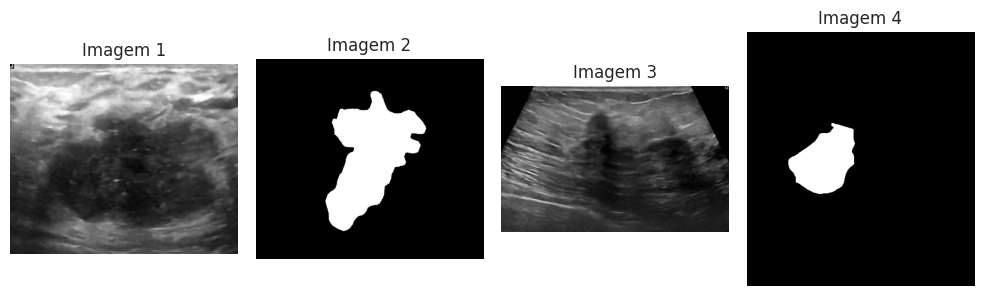


Mostrando imagens da pasta: normal


Exception ignored in: <function _xla_gc_callback at 0x79087d977640>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


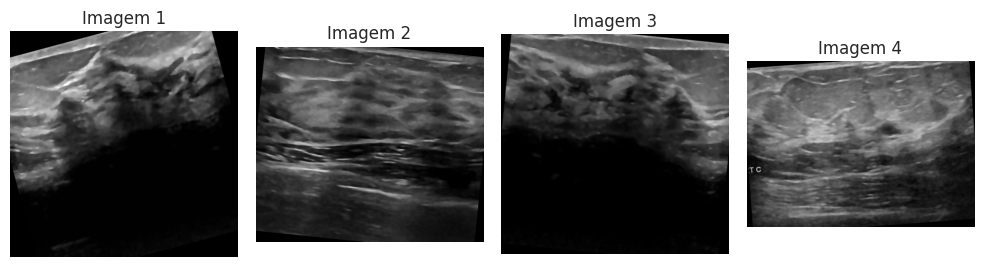

In [ ]:
# Função para mostrar algumas imagens
def display_images(directory, num_images=4):
    images_displayed = 0
    plt.figure(figsize=(10, 10))

    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                if images_displayed >= num_images:
                    break
                file_path = os.path.join(subdir, file)
                image = cv2.imread(file_path)

                # Mostrar a imagem
                plt.subplot(1, num_images, images_displayed + 1)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title(f'Imagem {images_displayed + 1}')
                plt.axis('off')

                images_displayed += 1

        if images_displayed >= num_images:
            break

    plt.tight_layout()
    plt.show()

# Processar e mostrar as imagens no diretório raiz
for category in counts.keys():
    print(f'\nMostrando imagens da pasta: {category}')
    category_dir = os.path.join(root_dir, category)
    display_images(category_dir)


# Balanceando

Contagem antes do balanceamento: {'benign': 891, 'malignant': 421, 'normal': 266}
Criando 470 novas imagens para /content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant...
Criando 625 novas imagens para /content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal...
Contagem após o balanceamento: {'benign': 891, 'malignant': 891, 'normal': 891}


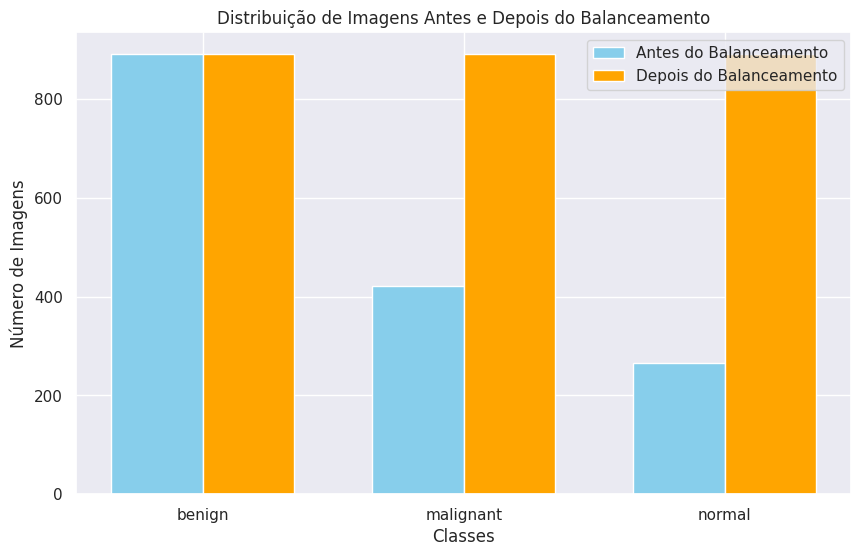

In [ ]:
import os
import numpy as np
from PIL import Image
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

# Função para fazer data augmentation e salvar novas imagens
def augment_images(input_dir, output_dir, target_count):
    images = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(images)

    if current_count >= target_count:
        print(f"A pasta {input_dir} já está balanceada.")
        return current_count

    num_to_create = target_count - current_count
    aug = iaa.Sequential([
        iaa.Affine(rotate=(-25, 25)),
        iaa.Fliplr(0.5),
        iaa.Multiply((0.8, 1.2)),
    ])

    print(f"Criando {num_to_create} novas imagens para {input_dir}...")

    for i in range(num_to_create):
        img_path = np.random.choice(images)
        image = Image.open(img_path)
        image_array = np.array(image)

        augmented_image = aug(image=image_array)
        augmented_pil = Image.fromarray(augmented_image)

        save_path = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(img_path))[0]}_aug_{i}.png")
        augmented_pil.save(save_path)

    return len(os.listdir(input_dir))

# Função para contar imagens
def count_images(directory, categories):
    counts = {}
    for category in categories:
        category_dir = os.path.join(directory, category)
        counts[category] = len([f for f in os.listdir(category_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    return counts

# Caminho do diretório raiz
root_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
categories = ['benign', 'malignant', 'normal']

# Contagem antes do balanceamento
counts_before = count_images(root_dir, categories)
print("Contagem antes do balanceamento:", counts_before)

# Balancear as classes
target_count = counts_before['benign']  # Número de imagens de 'benign'
counts_after = {
    'benign': counts_before['benign'],
    'malignant': augment_images(os.path.join(root_dir, 'malignant'), os.path.join(root_dir, 'malignant'), target_count),
    'normal': augment_images(os.path.join(root_dir, 'normal'), os.path.join(root_dir, 'normal'), target_count)
}

# Contagem após o balanceamento
counts_after = count_images(root_dir, categories)
print("Contagem após o balanceamento:", counts_after)

# Plotar gráfico de distribuição
def plot_distribution(counts_before, counts_after):
    categories = counts_before.keys()
    values_before = list(counts_before.values())
    values_after = list(counts_after.values())

    x = np.arange(len(categories))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, values_before, width, label='Antes do Balanceamento', color='skyblue')
    plt.bar(x + width/2, values_after, width, label='Depois do Balanceamento', color='orange')

    plt.xlabel('Classes')
    plt.ylabel('Número de Imagens')
    plt.title('Distribuição de Imagens Antes e Depois do Balanceamento')
    plt.xticks(x, categories)
    plt.legend()

    plt.show()

# Exibir o gráfico
plot_distribution(counts_before, counts_after)


In [ ]:
import os
from PIL import Image

# Defina o diretório onde as imagens estão armazenadas
root_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Função para obter as dimensões das imagens
def get_image_dimensions(root_dir):
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                try:
                    # Abra a imagem e obtenha suas dimensões
                    with Image.open(image_path) as img:
                        width, height = img.size
                        print(f'Imagem: {image_name} | Dimensões: {width}x{height}')
                except Exception as e:
                    print(f"Erro ao abrir {image_name}: {e}")

# Chame a função
get_image_dimensions(root_dir)

Imagem: normal (2)_mask.png | Dimensões: 224x224
Imagem: normal (38).png | Dimensões: 224x224
Imagem: normal (39).png | Dimensões: 224x224
Imagem: normal (30).png | Dimensões: 224x224
Imagem: normal (110)_mask.png | Dimensões: 224x224
Imagem: normal (133).png | Dimensões: 224x224
Imagem: normal (74)_mask.png | Dimensões: 224x224
Imagem: normal (20)_mask.png | Dimensões: 224x224
Imagem: normal (3)_mask.png | Dimensões: 224x224
Imagem: normal (104)_mask.png | Dimensões: 224x224
Imagem: normal (46)_mask.png | Dimensões: 224x224
Imagem: normal (65).png | Dimensões: 224x224
Imagem: normal (65)_mask.png | Dimensões: 224x224
Imagem: normal (113).png | Dimensões: 224x224
Imagem: normal (5).png | Dimensões: 224x224
Imagem: normal (87).png | Dimensões: 224x224
Imagem: normal (75).png | Dimensões: 224x224
Imagem: normal (125).png | Dimensões: 224x224
Imagem: normal (3).png | Dimensões: 224x224
Imagem: normal (75)_mask.png | Dimensões: 224x224
Imagem: normal (10)_mask.png | Dimensões: 224x224
Imag

# Modelo

In [ ]:
import os

# Diretório raiz
root_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Função para contar imagens em cada categoria
def count_images(directory):
    counts = {'benign': 0, 'malignant': 0, 'normal': 0}

    for category in counts.keys():
        category_dir = os.path.join(directory, category)
        if os.path.isdir(category_dir):
            for file in os.listdir(category_dir):
                if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                    counts[category] += 1

    return counts

# Chamar a função e exibir os resultados
image_counts = count_images(root_dir)

for category, count in image_counts.items():
    print(f'Pasta {category}: {count} imagens')


Pasta benign: 891 imagens
Pasta malignant: 891 imagens
Pasta normal: 891 imagens


In [ ]:
# Diretório raiz
root_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Função para carregar imagens e máscaras
def load_images_and_masks(directory):
    images = []
    masks = []

    for label in ['benign', 'malignant', 'normal']:
        class_dir = os.path.join(directory, label)

        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found: {class_dir}")
            continue

        for file in os.listdir(class_dir):
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                image_path = os.path.join(class_dir, file)

                mask_file_name = file.split('.')[0] + '_mask.png'
                mask_path = os.path.join(class_dir, mask_file_name)

                if not os.path.exists(mask_path):
                    print(f"Warning: Mask file not found for image: {image_path}")
                    continue

                image = cv2.imread(image_path)
                image = cv2.resize(image, (224, 224)).astype('float32') / 255.0  # Normalizar e converter para float32

                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is not None:
                    mask = cv2.resize(mask, (224, 224)).astype('float32') / 255.0  # Normalizar e converter para float32
                else:
                    print(f"Warning: Failed to load mask: {mask_path}")
                    continue

                images.append(image)
                masks.append(mask)

    if len(images) == 0 or len(masks) == 0:
        print("Erro: Nenhuma imagem ou máscara foi carregada.")
        return np.array([]), np.array([])

    return np.array(images), np.array(masks)

# Carregar imagens e máscaras
X, y = load_images_and_masks(root_dir)

# Verificar se as imagens e máscaras foram carregadas corretamente
if X.size == 0 or y.size == 0:
    print("Erro ao carregar as imagens ou máscaras.")
else:
    print(f"Total de imagens carregadas: {X.shape[0]}")
    print(f"Total de máscaras carregadas: {y.shape[0]}")

    # Dividir os dados em treino e validação
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Dados de treino: {X_train.shape}, {y_train.shape}")
    print(f"Dados de validação: {X_val.shape}, {y_val.shape}")


Total de imagens carregadas: 780
Total de máscaras carregadas: 780
Dados de treino: (624, 224, 224, 3), (624, 224, 224)
Dados de validação: (156, 224, 224, 3), (156, 224, 224)


In [ ]:
def build_resnet50_unet(input_shape):
    inputs = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Encoder: Extração de características
    c1 = base_model.get_layer("conv1_relu").output
    c2 = base_model.get_layer("conv2_block3_out").output
    c3 = base_model.get_layer("conv3_block4_out").output
    c4 = base_model.get_layer("conv4_block6_out").output
    c5 = base_model.get_layer("conv5_block3_out").output

    # Decoder: Construção da U-Net
    u1 = UpSampling2D(size=(2, 2))(c5)
    u1 = Conv2D(512, (3, 3), activation="relu", padding="same")(u1)
    u1 = concatenate([u1, c4])

    u2 = UpSampling2D(size=(2, 2))(u1)
    u2 = Conv2D(256, (3, 3), activation="relu", padding="same")(u2)
    u2 = concatenate([u2, c3])

    u3 = UpSampling2D(size=(2, 2))(u2)
    u3 = Conv2D(128, (3, 3), activation="relu", padding="same")(u3)
    u3 = concatenate([u3, c2])

    u4 = UpSampling2D(size=(2, 2))(u3)
    u4 = Conv2D(64, (3, 3), activation="relu", padding="same")(u4)
    u4 = concatenate([u4, c1])

    u5 = UpSampling2D(size=(2, 2))(u4)
    u5 = Conv2D(32, (3, 3), activation="relu", padding="same")(u5)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(u5)

    model = Model(inputs, outputs)
    return model

model = build_resnet50_unet((224, 224, 3))
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 37,707,649 (143.84 MB)

 Trainable params: 37,654,529 (143.64 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8031 - loss: 0.6144
Epoch 1: val_loss improved from inf to 0.34809, saving model to best_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8053 - loss: 0.6073 - val_accuracy: 0.9155 - val_loss: 0.3481
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9415 - loss: 0.1375
Epoch 2: val_loss did not improve from 0.34809
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 397ms/step - accuracy: 0.9415 - loss: 0.1374 - val_accuracy: 0.9155 - val_loss: 0.3747
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9475 - loss: 0.1004
Epoch 3: val_loss did not improve from 0.34809
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.9477 - loss: 0.1000 - val_accuracy: 0.9155 - val_loss: 0.3942
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9648 - loss: 0.0624
Epoch 4: val_loss improved from 0.34809 to 0.26012, saving model to best_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 610ms/step - 

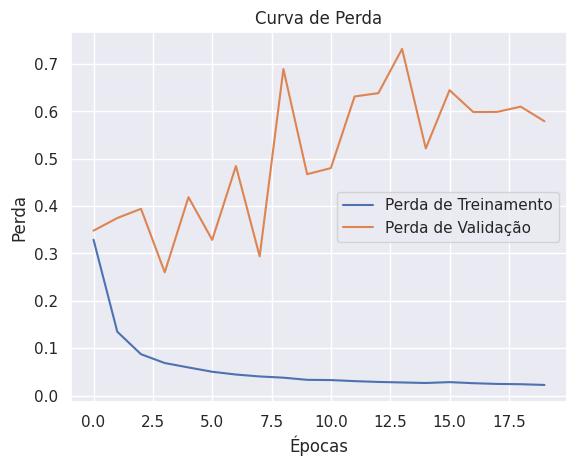

5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.9192 - loss: 0.5727
Perda: 0.5790270566940308
Acurácia: 0.9174172878265381


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Curva de Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

loss, accuracy = model.evaluate(X_val, y_val)
print(f'Perda: {loss}')
print(f'Acurácia: {accuracy}')
